In [37]:
%matplotlib inline
%matplotlib widget
#%matplotlib notebook
import json
import os
import pprint
import datetime as dt
from matplotlib import pyplot as plt
from matplotlib.container import BarContainer

import numpy as np
import math
import pandas as pd
import textwrap

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from ipywidgets import interact, interact_manual, Layout
import IPython.display
from IPython.display import display, clear_output
import mplcursors
from matplotlib.legend_handler import HandlerLine2D
from collections import Counter
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates 
import copy

#import plotly.graph_objects as go

In [42]:
class digest_query:
    def __init__(self, query_id, digest, digest_text, time_ms, cpu_usage, io, count, timestamp):
        self.query_id = query_id
        self.digest = digest
        self.digest_text = digest_text
        self.value = [[timestamp, time_ms, cpu_usage, io, count]]
        self.time_ms = []
        self.cpu_usage = []
        self.io = []
        self.count = []
        self.timestamp = []
    
    def add_time(self, time_ms):
        self.value[-1][1]+=time_ms
    
    def add_timestamp(self, time_ms, cpu_usage, io, count, timestamp):
        self.value.append([timestamp, time_ms, cpu_usage, io, count])
    
    def print_digest_query(self):
        print(f'query_id={self.query_id}')
        print(f'digest={self.digest}')
        print(f'digest_text={self.digest_text}')
        print(f'time_ms={self.time_ms}')
        print(f'cpu_usage={self.cpu_usage}')
    
    def sort_timestamp(self):
        self.value = list(map(lambda x: [x[0], float(x[1]), float(x[2]), int(x[3]), int(x[4])], self.value))
        self.value = sorted(self.value, key=lambda x:x[0])
        for v in self.value:
            #print(v)
            self.time_ms.append(v[1]) 
            self.cpu_usage.append(v[2])
            self.timestamp.append(v[0])
            self.count.append(v[4])
            self.io.append(v[3])
        #new_count = list(np.diff(np.array(self.count)))
        #new_count.insert(0, 0)
        #print(new_count)
        #self.print_digest_query()
    
    def add_missing_value(self, all_timestamp):
        new_time_ms = []
        new_cpu_usage = []
        new_count = []
        new_io = []
        #print(f"len of all timestamp {len(all_timestamp)}")
        #print(f"len of self timestamp {len(self.timestamp)}")
        #print(f"len of self timems {len(self.time_ms)}")
        #print(f"len of self cpu {len(self.cpu_usage)}")
        #print("=------===bef misv===========")
        #print(all_timestamp)
        #print(self.timestamp)
        for time in all_timestamp:
            if time in self.timestamp: #b에서 val의 index
                
                new_time_ms.append(self.time_ms[self.timestamp.index(time)])
                new_cpu_usage.append(self.cpu_usage[self.timestamp.index(time)])
                new_count.append(self.count[self.timestamp.index(time)])
                new_io.append(self.io[self.timestamp.index(time)])
            else:
                new_time_ms.append(0)
                new_cpu_usage.append(0)
                new_count.append(0)
                new_io.append(0)
        #print(len(all_timestamp), len(new_time_ms), len(new_cpu_usage))
        self.time_ms = new_time_ms
        self.cpu_usage = new_cpu_usage
        self.count = new_count
        self.io = new_io
        
        self.timestamp = copy.deepcopy(all_timestamp)
#         print(f"len of all timestamp {len(all_timestamp)}")
#         print(f"len of self timestamp {len(self.timestamp)}")
#         print(f"len of self timems {len(self.time_ms)}")
#         print(f"len of self cpu {len(self.cpu_usage)}")
#         print("=------===aft misv===========")
    
    def merge(self, other_query): #other query가 반드시 더 새로 수집된 데이터로부터 구한 거라고 가정!!
        #print(len(self.time_ms))
        #print(len(other_query.time_ms))
        self.time_ms += other_query.time_ms
        #print("merge후", len(self.time_ms))
        self.cpu_usage += other_query.cpu_usage
        self.io += other_query.io
        self.count += other_query.count
        self.timestamp += other_query.timestamp

def update_data(path, dic, all_timestamp, last_import_timestamp, query_num):
    new_dic = {}
    new_timestamp =[]
    file_list = os.listdir(path)
    
    min_datetime = dt.datetime.now()

    
    for filename in file_list:
        file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
        if file_datetime <=last_import_timestamp:
            continue
        else:
            print(file_datetime)
            if min_datetime > file_datetime:
                min_datetime = file_datetime
        with open(os.path.join(path, filename), 'r') as f:
            # 같은 파일 내를 탐색
            new_timestamp.append(file_datetime)
            text = json.load(f)
            #io = text['metrics_data']["global"]["engine"]["innodb_status_io"]
            performance_schema = text['metrics_data']['global']['performance_schema']
            threads = performance_schema['threads']       
            tid_dic = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
            cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
            io = performance_schema['io'] 
            events_statements_history = performance_schema['events_statements_history'] # list of dic
            digest_list = []
            for event in events_statements_history:
                digest = event['digest']
                if digest is None:
                    continue
                #print(category(digest))
                thread_id = event['thread_id']
                digest_text = event['digest_text']
                count = event['count']
                time = event['time_ms']
                if digest in digest_list: # 같은 쿼리가 같은 시간대에 이미 존재할 경우? time만 합친다.
                    new_dic[digest].add_time(time)
                elif digest in new_dic.keys():
                    if str(tid_dic[thread_id]) in io.keys():
                        new_dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        new_dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                else:
                    if str(tid_dic[thread_id]) in io.keys():
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                    #key error 발생
                    new_dic[digest] = temp
                    query_num+=1
                digest_list.append(digest)
    new_timestamp.sort()
    for query in new_dic:
        query_id = new_dic[query].query_id
        new_dic[query].sort_timestamp()
    #print(len(digest_list))
    
    add_digest_list = copy.deepcopy(digest_list)
    
    for new_query in digest_list: # 새로 추가된 digest = 즉, dict의 key, merge 할때마다 list에서 제거할것
        if new_query in dic.keys():
            dic[new_query].merge(new_dic[new_query])
            add_digest_list.remove(new_query)
    
    #print(len(digest_list))
    for new_digest in add_digest_list:
        dic[new_digest] = new_dic[new_digest]
    #print("all_timestamp before add",len(all_timestamp))
    all_timestamp+=new_timestamp
    #print("all_timestamp aft add",len(all_timestamp))
    for query in dic:
        dic[query].add_missing_value(all_timestamp)
        #print(len(dic[query].time_ms))
    print("MINDT : ",min_datetime)
    return dic, all_timestamp, query_num
                            
def Average(lst):
        return sum(lst) / len(lst)    

def import_data(path, time_range=dt.timedelta(hours=1)):
    dic = {}
    query_num = 0
    all_timestamp =[]
    file_list = os.listdir(path)
    max_datetime = dt.datetime.min
    for filename in file_list:
        file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
        if file_datetime <= dt.datetime.now() - time_range:
            print(file_datetime)
            if max_datetime < file_datetime:
                max_datetime = file_datetime
            #continue
        else:
            print(file_datetime)
            if max_datetime < file_datetime:
                max_datetime = file_datetime
        with open(os.path.join(path, filename), 'r') as f:
            # 같은 파일 내를 탐색
            all_timestamp.append(file_datetime)
            text = json.load(f)
            #io = text['metrics_data']["global"]["engine"]["innodb_status_io"]
            performance_schema = text['metrics_data']['global']['performance_schema']
            threads = performance_schema['threads']       
            tid_dic = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
            cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
            io = performance_schema['io'] 
            events_statements_history = performance_schema['events_statements_history'] # list of dic
            digest_list = []
            for event in events_statements_history:
                digest = event['digest']
                if digest is None:
                    continue
                thread_id = event['thread_id']
                digest_text = event['digest_text']
                count = event['count']
                time = event['time_ms']
                if digest in digest_list: # 같은 쿼리가 같은 시간대에 이미 존재할 경우? time만 합친다.
                    dic[digest].add_time(time)
                elif digest in dic.keys():
                    if str(tid_dic[thread_id]) in io.keys():
                        dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        dic[digest].add_timestamp(time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                else:
                    if str(tid_dic[thread_id]) in io.keys():
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], io[str(tid_dic[thread_id])], count, file_datetime)
                    else:
                        temp = digest_query(query_num, digest, digest_text, time, cpu_usage[str(tid_dic[thread_id])], 0, count, file_datetime)
                    #key error 발생
                    dic[digest] = temp
                    query_num+=1
                digest_list.append(digest)
    all_timestamp.sort()
    
    print("MAXDT : ",max_datetime)
    
    for query in dic:
        query_id = dic[query].query_id
        dic[query].sort_timestamp()
        dic[query].add_missing_value(all_timestamp)
    return dic, all_timestamp, query_num

def rank(dic, category, num, time_range):
    
    rank_list = []
    dic_by_id={}
    for query in dic:
        query_id = dic[query].query_id
        dic_by_id[query_id] = dic[query]
        i=0
        for i, t in enumerate(dic[query].timestamp):
            if t > dic[query].timestamp[-1] - time_range:
                #print(i)
                break
        rank_list.append((dic[query].query_id, Average(dic[query].time_ms[i:]), Average(dic[query].cpu_usage[i:]), Average(dic[query].io[i:]), Average(dic[query].count[i:])))
    
    if category == 'CPU':
        cpu_top = sorted(rank_list, key=lambda x:-x[2])[:num]
        cpu_top_qid = [i[0] for i in cpu_top]
        return cpu_top_qid
    elif category == 'Duration':
        time_top = sorted(rank_list, key=lambda x:-x[1])[:num]
        time_top_qid = [i[0] for i in time_top]
        return time_top_qid
    elif category == 'Disk IO':
        disk_top = sorted(rank_list, key=lambda x:-x[3])[:num]
        disk_top_qid = [i[0] for i in disk_top]
        return disk_top_qid
    elif category == 'Execution Count':
        count_top = sorted(rank_list, key=lambda x:-x[4])[:num]
        count_top_qid = [i[0] for i in count_top]
        return count_top_qid

In [39]:
#fig, ax = plt.subplots(figsize=(10, 7))


path = "data"
all_timestamp =[]
dic={}


dic, all_timestamp, query_num = import_data(path)
last_import_time = dt.datetime.now()
print(last_import_time)
print("Data Loading Complete!")

2022-08-10 13:42:20
2022-08-10 13:38:30
2022-08-10 13:36:00
2022-08-10 13:42:10
2022-08-10 13:38:00
2022-08-10 13:40:40
2022-08-10 13:36:30
2022-08-10 13:39:10
2022-08-10 13:37:20
2022-08-10 13:41:50
2022-08-10 13:39:20
2022-08-10 13:37:10
2022-08-10 13:41:20
2022-08-10 13:37:50
2022-08-10 13:39:50
2022-08-10 13:41:10
2022-08-10 13:38:40
2022-08-10 13:40:00
2022-08-10 13:36:40
2022-08-10 13:40:30
2022-08-10 13:36:50
2022-08-10 13:38:50
2022-08-10 13:40:21
2022-08-10 13:40:10
2022-08-10 13:39:40
2022-08-10 13:41:00
2022-08-10 13:41:30
2022-08-10 13:37:40
2022-08-10 13:39:30
2022-08-10 13:35:50
2022-08-10 13:37:00
2022-08-10 13:39:00
2022-08-10 13:37:30
2022-08-10 13:41:40
2022-08-10 13:42:00
2022-08-10 13:38:10
2022-08-10 13:40:50
2022-08-10 13:36:20
2022-08-10 13:38:20
2022-08-10 13:36:10
MAXDT :  2022-08-10 13:42:20
2022-08-13 00:44:14.640009
Data Loading Complete!


In [44]:

#cpu_top_qid = rank(dic, 'CPU', num)
def x_pad(x, window_size):
    x_pad_size = (window_size-(len(x) % window_size)) % window_size
    if x_pad_size >0:
        for i in range(x_pad_size):
            x.append(dt.datetime.now())
    return x

def visualize(category, num, time_range, m_agg='avg'):
    global dic, all_timestamp, last_import_time, query_num
    def update_prop(handle, orig):
            handle.update_from(orig)
            x,y = handle.get_data()
            handle.set_data([np.mean(x)]*2, [0, 2*y[0]])
    def resample(inp_array,window_size,how='avg'):
        inp_array = np.asarray(inp_array)
        #print(inp_array)
        #check how many zeros need to be added to the end to make
        #   the array length a multiple of window_size 
        pad = (window_size-(inp_array.size % window_size)) % window_size
        if pad > 0:
            inp_array = np.r_[np.ndarray.flatten(inp_array),np.zeros(pad)]
        else:
            inp_array = np.ndarray.flatten(inp_array)

        #reshape so that the number of columns = window_size
        inp_windows = inp_array.reshape((inp_array.size//window_size,window_size))

        if how == 'max':
           #sum across columns
           return np.max(inp_windows,axis=1)
        elif how == 'avg':
            return np.average(inp_windows,axis=1)
        elif how == 'min':
            return np.min(inp_windows,axis=1)
        else:
            raise NotImplementedError #replace this with other how's you want


    if category == 'CPU':
        fig = plt.figure(1)
        plt.close(1)    
        
        if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
            dic, all_timestamp, query_num = update_data(path,  dic, all_timestamp,last_import_time, query_num)
            last_import_time = dt.datetime.now()
            print(last_import_time)
            print("Data Update Complete!")
        
        cpu_top_qid = rank(dic, 'CPU', num, time_range)
        plt.clf()
        for query in dic:
            if dic[query].query_id in cpu_top_qid:
                x = all_timestamp
                #print("before x",len(x))
                #|print(dic[query].print_digest_query())
                y = np.array(dic[query].cpu_usage, dtype=np.float64)
                mask = (y != 0)
                x = [i for indx,i in enumerate(x) if mask[indx] == True]
                y = y[y!=0]
                #print("before y",len(y))
                #x = x[:1000+10*i]
                #y = y[:1000+10*i] # Truncate
                window_size = 10
                x = x_pad(x, window_size)
                
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                #print("afterx x",len(x))
                #print("after y",len(y))
                assert len(x) == len(y)
                
                plt.plot_date(x, y, xdate = True, ms=0,  ls = '-',label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20])
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5),handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
        plt.title(f"CPU usage per query\nfor queries with top {num} CPU usage", size=20, fontweight="bold")
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        mplcursors.cursor(plt.gcf(), highlight=True, hover = True) 
        
#         def do_animation():
#             fig = plt.figure(1)
#             plt.close(1)
#             def visualize_CPU(i):
#                 dic, all_timestamp = import_data(path, time_range)
#                 plt.cla()
#                 cpu_top_qid = rank(dic, 'CPU', num)
#                 for query in dic:
#                     if dic[query].query_id in cpu_top_qid:
#                         x = all_timestamp
#                         y = np.array(dic[query].cpu_usage, dtype=np.float64)

#                         #x = x[:1000+10*i]
#                         #y = y[:1000+10*i] # Truncate

#                         x = x[::10]
#                         y = resample(y, 10, how=m_agg) # Rollup, Aggregate

#                         plt.plot_date(x, y, xdate = True, ms=0,  ls = '-',label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20])
#                 plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5),handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
#                 plt.title(f"CPU usage per query\nfor queries with top {num} CPU usage", size=20, fontweight="bold")
#                 plt.xlim(dt.now()-time_range,dt.now())
#                 plt.gcf().autofmt_xdate()
#                 plt.grid(True, axis='y')
#                 plt.tight_layout()
#                 mplcursors.cursor(plt.gcf(), highlight=True, hover = True)
#             call[0] = FuncAnimation(plt.gcf(), visualize_CPU, interval = 5000)
#             #return call
#         #call_save = 
#         do_animation()
        
        
#         plt.gcf().autofmt_xdate()
#         plt.grid(True, axis='y')
#         plt.tight_layout()
#         mplcursors.cursor(plt.gcf(), highlight=True, hover = True)    
        plt.show()
    elif category == 'Duration':
        fig = plt.figure(2)
        plt.close(2)    
        if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
            dic, all_timestamp, query_num = update_data(path,  dic, all_timestamp,last_import_time, query_num)
            last_import_time = dt.datetime.now()
            print(last_import_time)
            print("Data Update Complete!")
        plt.clf()
        time_top_qid = rank(dic,'Duration', num, time_range)
        for query in dic:
            if dic[query].query_id in time_top_qid:
                zero = []
                x = all_timestamp
                y = np.array(dic[query].time_ms, dtype=np.float64)
                
                mask = (y != 0)
                x = [i for indx,i in enumerate(x) if mask[indx] == True]
                y = y[y!=0]
                        
                #x = x[:1000+10*i]
                #y = y[:1000+10*i] # Truncate
                
                window_size = 10
                x = x_pad(x, window_size)
                
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                #print(len(x))
                #print(len(y))
                assert len(x) == len(y)
                plt.plot_date(x, y, xdate = True, ms=0,  ls = '-',label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20])
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5),handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
        plt.title(f"Query latency\nfor top {num} slowest queries", size=20, fontweight="bold")
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        mplcursors.cursor(plt.gcf(), highlight=True, hover = True)     
        plt.show()

    
    elif category == 'Disk IO':
        fig = plt.figure(3)
        plt.close(3)
        if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
            dic, all_timestamp, query_num = update_data(path, dic, all_timestamp, last_import_time, query_num)
            last_import_time = dt.datetime.now()
            print(last_import_time)
            print("Data Update Complete!")
        
        plt.clf()
        disk_top_qid = rank(dic,'Disk IO', num, time_range)
        for query in dic:
            if dic[query].query_id in disk_top_qid:
                x = all_timestamp
                y = np.array(dic[query].io, dtype=np.float64)
                mask = (y != 0)
                x = [i for indx,i in enumerate(x) if mask[indx] == True]
                y = y[y!=0]
                window_size = 10
                x = x_pad(x, window_size)
                
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                #print(len(x))
                #print(len(y))
                assert len(x) == len(y)
                plt.plot_date(x, y, xdate = True, ms=0,  ls = '-', label=str(dic[query].query_id)+ " " + dic[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Disk IO per query\nfor queries with top {num} Disk IO", size=20, fontweight="bold")
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        mplcursors.cursor(plt.gcf(), highlight=True, hover = True)     
        plt.show()


    elif category == 'Execution Count':
        fig = plt.figure(4)
        plt.close(4)
        if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
            dic, all_timestamp, query_num = update_data(path,  dic, all_timestamp,last_import_time, query_num)
            last_import_time = dt.datetime.now()
            print(last_import_time)
            print("Data Update Complete!")
        
        plt.clf()
        count_top_qid = rank(dic,'Execution Count', num, time_range)
        for query in dic:
            if dic[query].query_id in count_top_qid:
                x = all_timestamp
                y = np.array(dic[query].count, dtype=np.float64)
                mask = (y != 0)
                x = [i for indx,i in enumerate(x) if mask[indx] == True]
                y = y[y!=0]
                window_size = 10
                x = x_pad(x, window_size)
                
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                #print(len(x))
                #print(len(y))
                assert len(x) == len(y)
                plt.plot_date(x, y, xdate = True, ms=0,  ls = '-', label=str(dic[query].query_id)+ " " + dic[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Execution Count for queries\nwith top {num} execution count", size=20, fontweight="bold")
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        mplcursors.cursor(plt.gcf(), highlight=True, hover = True)     
        plt.show()
    
def visualize_bar(category, num, time_range, m_agg='avg'):
    global dic, all_timestamp, last_import_time, query_num
    def update_prop(handle, orig):
            handle.update_from(orig)
            x,y = handle.get_data()
            handle.set_data([np.mean(x)]*2, [0, 2*y[0]])
    def resample(inp_array,window_size,how='avg'):
        inp_array = np.asarray(inp_array)
        #print(inp_array)
        #check how many zeros need to be added to the end to make
        #   the array length a multiple of window_size 
        pad = (window_size-(inp_array.size % window_size)) % window_size
        if pad > 0:
            inp_array = np.r_[np.ndarray.flatten(inp_array),np.zeros(pad)]
        else:
            inp_array = np.ndarray.flatten(inp_array)

        #reshape so that the number of columns = window_size
        inp_windows = inp_array.reshape((inp_array.size//window_size,window_size))

        if how == 'max':
           #sum across columns
           return np.max(inp_windows,axis=1)
        elif how == 'avg':
            return np.average(inp_windows,axis=1)
        elif how == 'min':
            return np.min(inp_windows,axis=1)
        else:
            raise NotImplementedError #replace this with other how's you want

    def show_annotation(sel):
        if type(sel.artist) == BarContainer:
            bar = sel.artist[sel.target.index]
            sel.annotation.set_text(f'{sel.artist.get_label()}: {bar.get_height():.1f}')
            sel.annotation.xy = (bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2)
            sel.annotation.get_bbox_patch().set_alpha(0.8)

    if category == 'CPU':
        fig = plt.figure(1)
        plt.close(1)    
        bottom = []
        
        # Deactivate Update (for debug)
#         if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
#             dic, all_timestamp, query_num = update_data(path,  dic, all_timestamp,last_import_time, query_num)
#             last_import_time = dt.datetime.now()
#             print(last_import_time)
#             print("Data Update Complete!")
        
        cpu_top_qid = rank(dic, 'CPU', num, time_range)
        plt.clf()
        for query in dic:
            if dic[query].query_id in cpu_top_qid:
                
                x = all_timestamp
                #print("before x",len(x))
                #|print(dic[query].print_digest_query())
                y = np.array(dic[query].cpu_usage, dtype=np.float64)
                window_size = 10
                x = x_pad(x, window_size)
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                #print("afterx x",len(x))
                #print("after y",len(y))
                assert len(x) == len(y)
                
                if len(bottom)==0:
                    bottom = np.zeros(len(x))

                width = np.min(np.diff(mdates.date2num(x)))
                plt.bar(x, height = y, width = 0.8*width, ec='k' ,label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20], bottom = bottom)
                bottom += y
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5),handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
        plt.title(f"CPU usage per query\nfor queries with top {num} CPU usage", size=20, fontweight="bold")
        plt.gca().xaxis_date()
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        cursor = mplcursors.cursor(plt.gcf(), highlight=True, hover = True) 
        cursor.connect('add', show_annotation)
        plt.show()
        print_raw_data(dic, category, time_range, cpu_top_qid)


    elif category == 'Duration':
        fig = plt.figure(2)
        plt.close(2)
        bottom = []    
        # if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
        #     dic, all_timestamp, query_num = update_data(path,  dic, all_timestamp,last_import_time, query_num)
        #     last_import_time = dt.datetime.now()
        #     print(last_import_time)
        #     print("Data Update Complete!")
        plt.clf()
        time_top_qid = rank(dic,'Duration', num, time_range)
        for query in dic:
            if dic[query].query_id in time_top_qid:
                x = all_timestamp
                y = np.array(dic[query].time_ms, dtype=np.float64)

                window_size = 10
                x = x_pad(x, window_size)
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                #print(len(x))
                #print(len(y))
                assert len(x) == len(y)
                if len(bottom)==0:
                    bottom = np.zeros(len(x))
                width = np.min(np.diff(mdates.date2num(x)))
                plt.bar(x, height = y, width = 0.0003,label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20], bottom = bottom)
                bottom += y
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5),handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
        plt.title(f"Query latency\nfor top {num} slowest queries", size=20, fontweight="bold")
        plt.gca().xaxis_date()
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        cursor = mplcursors.cursor(plt.gcf(), highlight=True, hover = True) 
        cursor.connect('add', show_annotation) 
        plt.show()
    elif category == 'Disk IO':
        fig = plt.figure(3)
        plt.close(3)
        bottom = []
        # if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
        #     dic, all_timestamp, query_num = update_data(path, dic, all_timestamp, last_import_time, query_num)
        #     last_import_time = dt.datetime.now()
        #     print(last_import_time)
        #     print("Data Update Complete!")
        
        plt.clf()
        disk_top_qid = rank(dic,'Disk IO', num, time_range)
        for query in dic:
            if dic[query].query_id in disk_top_qid:
                x = all_timestamp
                y = np.array(dic[query].io, dtype=np.float64)
                
                window_size = 10
                x = x_pad(x, window_size)
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                #print(len(x))
                #print(len(y))
                assert len(x) == len(y)
                if len(bottom)==0:
                    bottom = np.zeros(len(x))
                width = np.min(np.diff(mdates.date2num(x)))
                plt.bar(x, height = y, width = width, ec='k' ,label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20], bottom = bottom)
                bottom += y        
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Disk IO per query\nfor queries with top {num} Disk IO", size=20, fontweight="bold")
        plt.gca().xaxis_date()
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        cursor = mplcursors.cursor(plt.gcf(), highlight=True, hover = True) 
        cursor.connect('add', show_annotation)   
        plt.show()


    elif category == 'Execution Count':
        fig = plt.figure(4)
        plt.close(4)
        bottom = []
        # if dt.datetime.now()-last_import_time > dt.timedelta(minutes=1):
        #     dic, all_timestamp, query_num = update_data(path,  dic, all_timestamp,last_import_time, query_num)
        #     last_import_time = dt.datetime.now()
        #     print(last_import_time)
        #     print("Data Update Complete!")
        
        plt.clf()
        count_top_qid = rank(dic,'Execution Count', num, time_range)
        for query in dic:
            if dic[query].query_id in count_top_qid:
                x = all_timestamp
                y = np.array(dic[query].count, dtype=np.float64)
                
                window_size = 10
                x = x_pad(x, window_size)
                x = x[::window_size]
                y = resample(y, window_size, how=m_agg) # Rollup, Aggregate
                assert len(x) == len(y)
                if len(bottom)==0:
                    bottom = np.zeros(len(x))

                width = np.min(np.diff(mdates.date2num(x)))
                plt.bar(x, height = y, width = width, ec='k' ,label=str(dic[query].query_id) + " "+ dic[query].digest_text[:20], bottom = bottom)
                bottom += y
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title(f"Execution Count for queries\nwith top {num} execution count", size=20, fontweight="bold")
        plt.gca().xaxis_date()
        plt.xlim(x[-1]-time_range,x[-1])
        plt.gcf().autofmt_xdate()
        plt.grid(True, axis='y')
        plt.tight_layout()
        cursor = mplcursors.cursor(plt.gcf(), highlight=True, hover = True) 
        cursor.connect('add', show_annotation)
        plt.show()
    

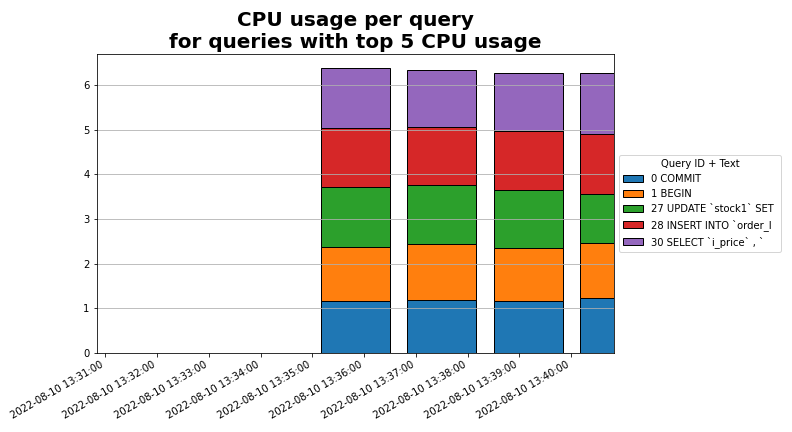

,Digest Text,CPU usage,Disk IO,Duration(ms),Execution Count
QID,,,,,
0,COMMIT,1.18425,23592.425,25.924507,5136.175
1,BEGIN,1.22175,24364.475,0.424268,5158.700
27,UPDATE `stock1` SET `s_quantity` = ? WHERE `s_i_id` = ? AND `s_w_id` = ?,1.26150,25499.225,30.591737,4929.925
28,"INSERT INTO `order_line1` ( `ol_o_id` , `ol_d_id` , `ol_w_id` , `ol_number` , `ol_i_id` , `ol_supply_w_id` , `ol_quantity` , `ol_amount` , `ol_dist_info` ) VALUES (...)",1.32800,26851.625,34.390068,22437.900
30,"SELECT `i_price` , `i_name` , `i_data` FROM `item1` WHERE `i_id` = ?",1.32050,26711.775,20.037950,22438.350


Select(description='Select QID', layout=Layout(height='100px', width='40%'), options=(0, 1, 27, 28, 30), value…

Output()

In [98]:
style = {'description_width': 'initial'}
layout = widgets.Layout(
                align_items='center',
                width= '80%',
)

w1 = widgets.Dropdown(
    options=['CPU', 'Disk IO', 'Duration', 'Execution Count'],
    value='CPU',
    #description='Metric type:',
    style = style,
    layout = layout,
)
w2 = widgets.Dropdown(
    options=['Last 1 min', 'Last 5 min','Last 10 min','Last 1 hr', 'Last 6 hrs', 'Last 24 hrs', 'past week', 'past month', 'custom'],
    value='Last 10 min',
    #description='Time Period:',
    style = style,
    layout = layout,
)
w3 = widgets.Dropdown(
    options=['5','10','15'],
    value='5',
    #description='# of queries:',
    style = style,
    layout=Layout(flex='1 1 25%', align_items='center', width='80%'),
)
w4 = widgets.Dropdown(
    options=['Not implemented yet'],
    value='Not implemented yet',
    #description='Query aggregation:',
    style = style,
    layout = layout,
)
w5 = widgets.Dropdown(
    options=['avg','min','max'],
    value='avg',
    #description='Metrics aggregation:',
    style = style,
    layout = layout,
)

button = widgets.Button(description='Draw', color = 'blue',
                        layout=Layout(flex='2 1 50%', align_items='center', width='80%'),)



def on_click_callback(clicked_button: widgets.Button) -> None:
    """버튼이 눌렸을 때 동작하는 이벤트 핸들러"""
    plt.close(1)
    plt.close(2)
    plt.close(3)
    plt.close(4)
    num= int(w3.value)
    if w2.value == 'Last 1 min':
        time_range = dt.timedelta(minutes = 1)
    elif w2.value == 'Last 5 min':
        time_range = dt.timedelta(minutes = 5)
    elif w2.value == 'Last 10 min':
        time_range = dt.timedelta(minutes = 10)
    elif w2.value == 'Last 1 hr':
        time_range = dt.timedelta(hours = 1)
    elif w2.value == 'Last 6 hrs':
        time_range = dt.timedelta(hours = 6)
    elif w2.value == 'Last 24 hrs':
        time_range = dt.timedelta(hours = 24)
    clear_output(wait = True)
    display(HBox(widget_list))
    visualize_bar(w1.value, num, time_range, w5.value)

plt.figure(1) # CPU
plt.figure(2) # Duration
plt.figure(3) # Disk IO
plt.figure(4) # Execution Count
plt.close(1)
plt.close(2)
plt.close(3)
plt.close(4)
clear_output(wait = True)
plt.rcParams['figure.figsize'] = [11, 6]
plt.rcParams["date.autoformatter.minute"] = "%Y-%m-%d %H:%M:%S"
plt.ion()


lb1 = widgets.Label('Metrics category:')
lb2 = widgets.Label('Time period:')
lb3 = widgets.Label('# of queries:',layout=Layout(flex='1 1 25%', width='auto'))
lb4 = widgets.Label('Query aggregation:')
lb5 = widgets.Label('Metrics aggregation:')


button.on_click(on_click_callback)
h1 = VBox([lb1,w1,lb4, w4], layout = layout)
h2 = VBox([lb2,w2,lb5, w5], layout = layout)
h3 = VBox([lb3,w3, button], layout=widgets.Layout(flex_flow='column',align_items='center',
                width= '80%',))
widget_list = [h1,h2,h3]

display(HBox(widget_list, layout=Layout( width='auto')))

In [97]:
import qgrid
from matplotlib.widgets import MultiCursor

def print_raw_data(dic, category, time_range,top_qid):
    # category: 어떤 것에 대한 top query들인지
    #df = pd.DataFrame(columns=['QID','Digest Text','CPU usage','Disk IO','Duration(ms)','Execution Count'])
    data = []
    for query in dic:
        qid = dic[query].query_id
        i=0
        for i, t in enumerate(dic[query].timestamp):
            if t > dic[query].timestamp[-1] - time_range:
                #print(i)
                break
    
        if qid in top_qid:
            data.append([qid, dic[query].digest_text, Average(dic[query].cpu_usage[i:]),Average(dic[query].io[i:]),Average(dic[query].time_ms[i:]),Average(dic[query].count[i:])])
                
    df = pd.DataFrame(data, columns = ['QID', 'Digest Text','CPU usage','Disk IO','Duration(ms)','Execution Count'])
    df = df.set_index('QID')
    #qgrid.enable()
    #from itables import init_notebook_mode

    #init_notebook_mode(all_interactive=True)
    #display(df) # VSCODE에서는 안보인다고하네...
    from IPython.display import display, HTML

    display(HTML(df.to_html()))
    #print(df)
    dropdown = widgets.Select(
                        options=df.index,
                        description='Select QID',
                        disabled=False,
                        layout={'height':'100px', 'width':'40%'})
    def filter_dataframe(widget):
        global filtered_df
        selection = widget['new'] # qid?

        with out:
            #clear_output()
           # print(selection)
            for digest in dic:
                if dic[digest].query_id == selection:
                    q = dic[digest]
                    break
            x = q.timestamp
            #y = q.cpu_usage
            plt.close()
            fig, axes = plt.subplots(nrows=2, ncols=2)
            axes[0,0].plot(x,q.cpu_usage, label = "cpu usage")

            axes[0,1].plot(x,q.io, label = 'disk io')
            axes[1,0].plot(x,q.count, label = 'execution count')
            axes[1,1].plot(x,q.time_ms, label = 'execution time')
            axes[0, 0].set_title("cpu usage")
            axes[0, 1].set_title('disk io')
            axes[1, 0].set_title('execution count')
            axes[1, 1].set_title('execution time')
            fig.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
            fig.suptitle(f"Metrics for query ID {selection}", size=20, fontweight="bold")
            plt.gca().xaxis_date()
            plt.xlim(x[-1]-time_range,x[-1])
            plt.gcf().autofmt_xdate()
            plt.grid(True, axis='y')
            plt.tight_layout()
            multi = MultiCursor(fig.canvas, [axes[0][0],axes[0][1],axes[1][0],axes[1][1]], color='r', lw=1)
            cursor = mplcursors.cursor(plt.gcf(), hover = True)
            plt.show()
            #filtered_df = df.loc[selection]

    out = widgets.Output()
    dropdown.observe(filter_dataframe, names='value')
    display(dropdown)
    display(out)
    #widget = qgrid.show_grid(df)
    #widget

    # self.query_id = query_id
    #     self.digest = digest
    #     self.digest_text = digest_text
    #     self.value = [[timestamp, time_ms, cpu_usage, io, count]]
    #     self.time_ms = []
    #     self.cpu_usage = []
    #     self.io = []
    #     self.count = []
    #     self.timestamp = []
        